In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

# data

In [3]:
category = "ODO"
corrected_data = pd.read_csv("CorrectedData/LR_Mendon_AA_{0}_SourceID_1_QC_1.csv".format(category))

In [4]:
year = "2017"
raw_data = pd.read_csv("RawData/LR_Mendon_AA_SourceID_1_QC_0_Year_{0}.csv".format(year))

In [5]:
print("current dataset {0} {1}".format(category, year))
s_corr =corrected_data[(corrected_data["LocalDateTime"] >= year + "-01-01 00:00:00") & \
    (corrected_data["LocalDateTime"] <= year + "-12-31 23:59:59")]

current dataset ODO 2017


In [183]:
s_raw = raw_data[["LocalDateTime",category]]


In [6]:
def cal_error(s1, s2):
    return np.absolute(np.array(s1) - np.array(s2))

In [7]:
def gaussian(x, mu, sig):
    return 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2)

In [8]:
def cal_threshold():
    pass

# anomal classification method 1: random

### find the threshold of classification when f-score is best  e < threshold

In [9]:
def anomaly_random():
    pass

# anomaly classification method 2: gaussian distribution
compute parameters mean, variance of gaussian distribution and threshold

### using errors from corrected data and raw data to fit gaussian distribution

### find the threshold of classification when f-score is best p < threshold

# model 1: lstm

In [10]:
import tensorflow as tf
from tensorflow import keras

In [11]:
# def train_test_split(df, frac=0.8):
#     train_size = int(len(df) * frac)
#     test_size = len(df) - train_size
#     train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
#     print("The train size is {0}, test size is {1}".format(len(train), len(test)))    
#     return train, test

In [440]:
def create_dataset(X, y, history_size, target_size, time_steps=1):
    Xs, ys = [], []
    start_index = history_size
    end_index = len(X) - target_size
    for i in range(start_index, end_index): # add target_size
        indices = np.arange(i-history_size, i, time_steps)
        Xs.append(X.iloc[indices].values)
        indices = np.arange(i, i+target_size)
        ys.append(y.iloc[indices].values)
    return np.array(Xs), np.array(ys)

In [215]:
def create_dataset2(X, y, history_size, target_size, time_steps=1):
    Xs, ys = [], []
    Xt, yt = [], []
    start_index = history_size
    end_index = len(X) - target_size
    for i in range(start_index, end_index): # add target_size
        indices = np.arange(i-history_size, i, time_steps)
        Xs.append(X.iloc[indices].values)
        Xt.append(X.iloc[indices].index)
        indices = np.arange(i, i+target_size)
        ys.append(y.iloc[indices].values)
        yt.append(y.iloc[indices].index)
    return np.array(Xs), np.array(ys), np.array(Xt), np.array(yt)

In [139]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1,len(loss)+1)

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    
    plt.title(title)
    plt.legend()

    plt.show()

In [243]:
def plot_ts(history, true_future, prediction, time_steps, title=""):
    plt.figure(figsize=(12, 6))
    num_in = list(i * time_steps for i in range(-len(history), 0))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history), label='History') # col=1 is target column
    plt.plot(np.arange(num_out), np.array(true_future), 'g-',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out), np.array(prediction), 'r-',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.title(title)
#     plt.show()

In [78]:
RANDOM_SEED = 42
tf.random.set_seed(RANDOM_SEED)

def lstm(train, target, history_size, target_size, filepath, time_steps=1, params=None):
    
    # reshape to [samples, time_steps, n_features]
    X_train, y_train = create_dataset(train, train[target], history_size, target_size, time_steps)

    print("X_train shape is {0}, y_train shape is {1}".format(X_train.shape, y_train.shape))
    
    if not params:
        params = {
            "units": 128,
            "optimizer": f.keras.optimizers.Adam(),
            "num_layers": 1,
            "n_epoch":10,
            "batch_size": 200
        }
    
    model = keras.Sequential()
    model.add(keras.layers.LSTM(
      units=params["units"],
      input_shape=(X_train.shape[1], X_train.shape[2])
    ))
#     for _ in range(1,params["num_layers"]):
#         model.add(tf.keras.layers.LSTM(72, return_sequences=True, activation='relu'))

    model.add(keras.layers.Dense(units=target_size))
    model.compile(
      loss='mean_squared_error',
      optimizer=params["optimizer"]
    )
    
#     callback = tf.keras.callbacks.ModelCheckpoint(
#         filepath, monitor='val_loss', verbose=0, save_best_only=True,
#         save_weights_only=False, mode='auto', save_freq='epoch'
#     )



    model_history = model.fit(
        X_train, y_train,
        epochs=params["n_epoch"],
        batch_size=params["batch_size"],
#         callbacks=[callback],
        validation_split=0.1,
        verbose=1,
        shuffle=False
    )
    
    plot_train_history(model_history, 'multiple epochs Training and validation loss')
    
    return model
    

In [16]:
dataset = pd.DataFrame(s_corr[category])
dataset.index = s_corr["LocalDateTime"]
dataset.head()

,ODO
LocalDateTime,
2017-01-01 00:00:00,10.91
2017-01-01 00:15:00,10.91
2017-01-01 00:30:00,10.92
2017-01-01 00:45:00,10.93
2017-01-01 01:00:00,10.93


In [304]:
# 15 mins = 1 observation
dy = 96 # 1 day = 96 observations
hs = 7*dy # one month
ts = 1*dy # one week
tp = 4 # num of observations
train_split = 4000

In [163]:
train_set = dataset[:train_split]
# standarlize training data
train_mean = train_set.mean()
train_std = train_set.std()
train_set = (train_set - train_mean)/train_std

In [247]:
params = {
    "units": 128,
    "optimizer": tf.keras.optimizers.RMSprop(), #tf.keras.optimizers.Adam(),
    "num_layers": 1,
    "n_epoch":50,
    "batch_size": 200
}


In [441]:
# fp = "best_model.h5"
# lstm_model = lstm(train_set, train_set[category], history_size=hs, target_size=ts, filepath= fp, time_steps=tp, params=params)

KeyError: "None of [Float64Index([ -0.3238238135424759,  -0.3238238135424759,  -0.3125942605053803,\n              -0.30136470746828464, -0.30136470746828464, -0.29013515443118904,\n               -0.2789056013940934,  -0.2789056013940934, -0.26767604835699577,\n              -0.26767604835699577,\n              ...\n                -0.806694594137598,  -0.8291537002117892,  -0.8516128062859825,\n               -0.8740719123601738,  -0.8853014653972694,   -0.896531018434365,\n               -0.9189901245085563,  -0.9302196775456539,  -0.9414492305827495,\n               -0.9639083366569408],\n             dtype='float64', length=4000)] are in the [columns]"

X_train shape is (1984, 336, 1), y_train shape is (1984, 672)
Train on 1785 samples, validate on 199 samples
Epoch 1/50
1785/1785 [==============================] - 71s 40ms/sample - loss: 1.0354 - val_loss: 1.8139
Epoch 2/50
1785/1785 [==============================] - 16s 9ms/sample - loss: 0.8973 - val_loss: 1.7127
Epoch 3/50
1785/1785 [==============================] - 16s 9ms/sample - loss: 0.6899 - val_loss: 1.6533
Epoch 4/50
1785/1785 [==============================] - 19s 11ms/sample - loss: 0.6856 - val_loss: 1.6592
Epoch 5/50
1785/1785 [==============================] - 17s 9ms/sample - loss: 0.6001 - val_loss: 1.6857
Epoch 6/50
1785/1785 [==============================] - 17s 10ms/sample - loss: 0.6596 - val_loss: 1.7032
Epoch 7/50
1785/1785 [==============================] - 15s 8ms/sample - loss: 0.5485 - val_loss: 1.7385
Epoch 8/50
1785/1785 [==============================] - 15s 8ms/sample - loss: 0.5167 - val_loss: 1.7019
Epoch 9/50
1785/1785 [==========================

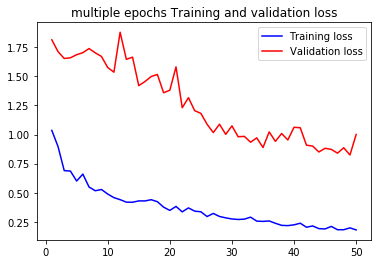

In [248]:
# dy = 96 # 1 day = 96 observations
# hs = 14*dy # one month
# ts = 7*dy # one week
# tp = 4 # num of observations
# train_split = 4000

# params = {
#     "units": 128,
#     "optimizer": tf.keras.optimizers.RMSprop(), #tf.keras.optimizers.Adam(),
#     "num_layers": 1,
#     "n_epoch":50,
#     "batch_size": 200
# }

# fp = "best_model.h5"
# lstm_model2 = lstm(train_set, target=category, history_size=hs, target_size=ts, filepath= fp, time_steps=tp, params=params)

In [235]:
test_set = dataset[train_split:train_split+3000]
test_set = (test_set - train_mean)/train_std
X_test, y_test = create_dataset(test_set, test_set[category],history_size=hs, target_size=ts, time_steps=tp)

In [238]:
y_pred = lstm_model.predict(X_test)

In [249]:
#test_set = dataset[train_split:train_split+3000]
#test_set = (test_set - train_mean)/train_std#
#X_test2, y_test2 = create_dataset(test_set, test_set[category],history_size=hs, target_size=ts, time_steps=tp)

In [302]:
#y_pred2 = lstm_model2.predict(X_test2)

ODO   -0.963908
Name: 2017-02-18 16:00:00, dtype: float64
ODO   -1.42432
Name: 2017-02-19 16:00:00, dtype: float64
ODO   -0.840383
Name: 2017-02-20 16:00:00, dtype: float64
ODO   -1.210959
Name: 2017-02-21 16:00:00, dtype: float64
ODO   -0.750547
Name: 2017-02-22 16:00:00, dtype: float64
ODO   -0.447349
Name: 2017-02-23 16:00:00, dtype: float64


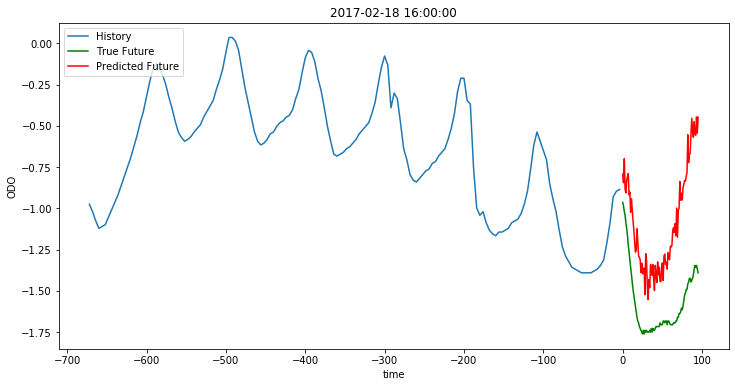

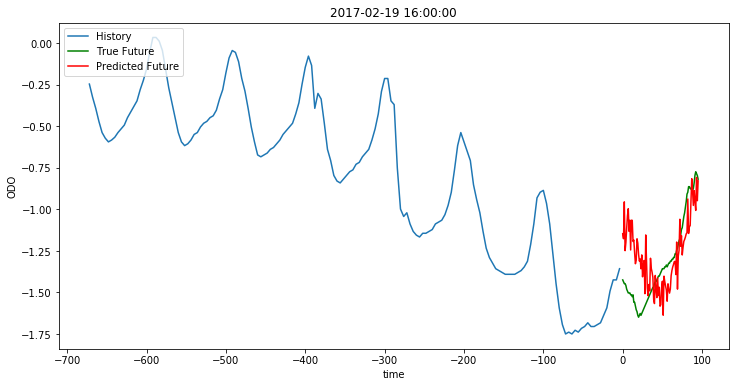

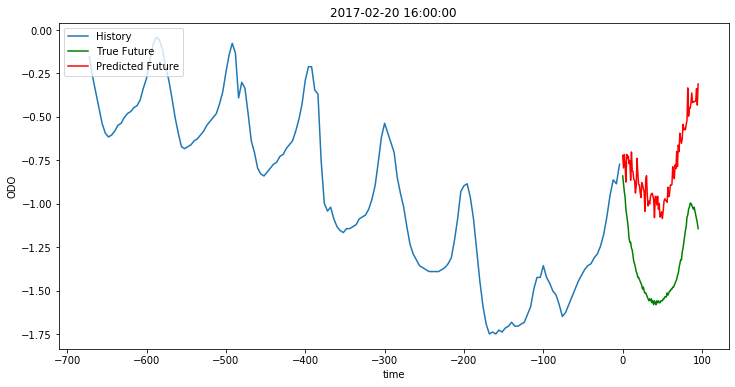

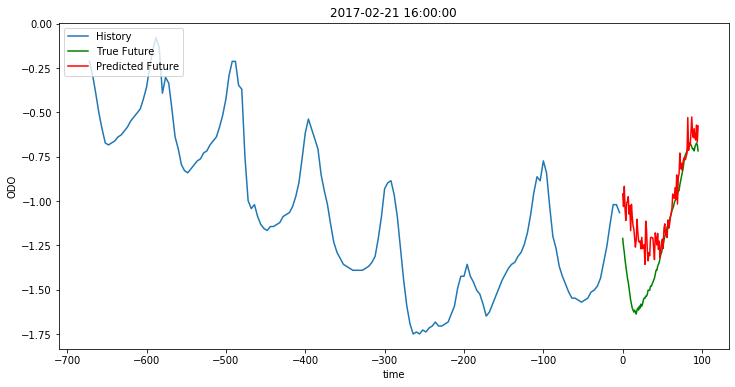

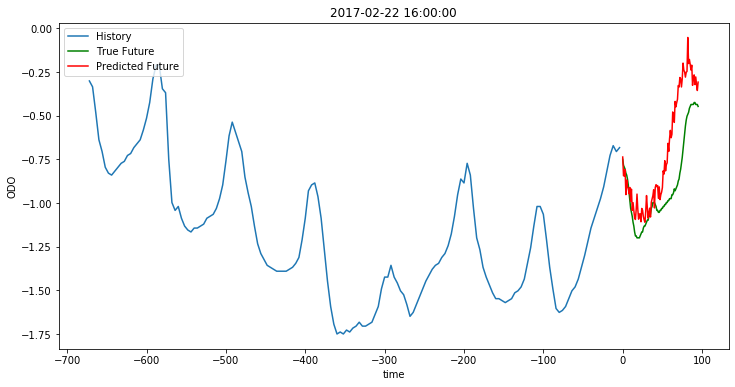

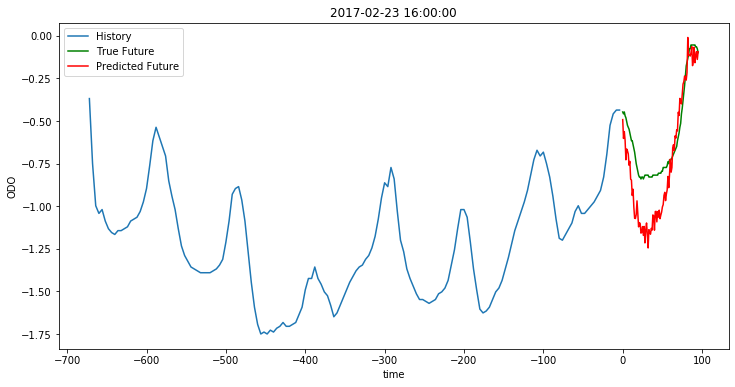

In [433]:
curr_t = hs
step = dy
for i in range(0,500,step):
    v = test_set.iloc[curr_t]
    print(v)
    plot_ts(X_test[i][:,0], y_test[i], y_pred[i], time_steps=tp)
    plt.title(v.name)
    plt.xlabel("time")
    plt.ylabel(v.index[0])
    curr_t += step
#     plt.savefig("day_pred{0}.png".format(v.name))

In [443]:
lstm_model

In [305]:
start_index = hs
end_index = len(test_set) - ts
start_index, end_index

(672, 2904)

In [306]:
start_time = test_set.iloc[hs].name
end_time = test_set.iloc[len(test_set) - ts].name
start_time, end_time

('2017-02-18 16:00:00', '2017-03-13 22:00:00')

In [307]:
y_raw = s_raw[(s_raw["LocalDateTime"] >= start_time) & \
              (s_raw["LocalDateTime"] <= end_time)]

In [308]:
# y_raw.set_index("LocalDateTime", inplace=True)

In [309]:
y_raw[y_raw["LocalDateTime"].str.contains('2017-02-21')]

,LocalDateTime,ODO
4887,2017-02-21 00:00:00,9.82
4888,2017-02-21 00:15:00,9.81
4889,2017-02-21 00:30:00,9.82
4890,2017-02-21 00:45:00,9.81
4891,2017-02-21 01:00:00,9.82
...,...,...
4978,2017-02-21 22:45:00,9.82
4979,2017-02-21 23:00:00,9.82
4980,2017-02-21 23:15:00,9.83
4981,2017-02-21 23:30:00,9.83


In [310]:
labels = s_corr[(s_corr["LocalDateTime"] >= start_time) & \
              (s_corr["LocalDateTime"] <= end_time)]

In [367]:
anomaly_labels = labels[labels["QualifierCode"].notnull()]
for _, v in anomaly_labels.iterrows():
    print("corrected",v)
    yrr = y_raw[y_raw["LocalDateTime"] == v["LocalDateTime"]]
    
    error_index = pd.Index(pd.Series(test_set.index)).get_loc(v["LocalDateTime"])
    y_test[error_index-start_index][0] * train_std + train_mean
    y_pred[error_index-start_index][0]* train_std + train_mean
    
    print("raw",yrr)
    print("y_test",ytt)
    print("y_pred", ypp)

corrected LocalDateTime    2017-02-20 00:00:00
UTCOffset                         -7
DateTimeUTC      2017-02-20 00:00:00
ODO                             9.83
CensorCode                        nc
QualifierCode                     LI
Name: 110016, dtype: object
raw Empty DataFrame
Columns: [LocalDateTime, ODO]
Index: []
y_test ODO    10.34
dtype: float64
y_pred ODO    10.491883
dtype: float64
corrected LocalDateTime    2017-02-27 00:00:00
UTCOffset                         -7
DateTimeUTC      2017-02-27 00:00:00
ODO                           10.515
CensorCode                        nc
QualifierCode                     LI
Name: 110688, dtype: object
raw Empty DataFrame
Columns: [LocalDateTime, ODO]
Index: []
y_test ODO    10.34
dtype: float64
y_pred ODO    10.491883
dtype: float64
corrected LocalDateTime    2017-03-06 00:00:00
UTCOffset                         -7
DateTimeUTC      2017-03-06 00:00:00
ODO                            10.13
CensorCode                        nc
QualifierCode    

In [368]:
anomaly_labels

,LocalDateTime,UTCOffset,DateTimeUTC,ODO,CensorCode,QualifierCode
110016,2017-02-20 00:00:00,-7.0,2017-02-20 00:00:00,9.830,nc,LI
110688,2017-02-27 00:00:00,-7.0,2017-02-27 00:00:00,10.515,nc,LI
111360,2017-03-06 00:00:00,-7.0,2017-03-06 00:00:00,10.130,nc,LI
111700,2017-03-09 13:00:00,-7.0,2017-03-09 20:00:00,10.852,nc,LI
111701,2017-03-09 13:15:00,-7.0,2017-03-09 20:15:00,10.884,nc,LI
111702,2017-03-09 13:30:00,-7.0,2017-03-09 20:30:00,10.916,nc,LI
111703,2017-03-09 13:45:00,-7.0,2017-03-09 20:45:00,10.948,nc,LI
112032,2017-03-13 00:00:00,-7.0,2017-03-13 00:00:00,9.835,nc,LI


In [326]:
error_index = pd.Index(pd.Series(test_set.index)).get_loc("2017-03-09 20:30:00")

In [327]:
y_test[error_index-start_index][0] * train_std + train_mean

ODO    9.82
dtype: float64

In [328]:
y_pred[error_index-start_index][0]* train_std + train_mean

ODO    10.061204
dtype: float64

In [490]:
yt = []
start_index = hs
end_index = len(test_set) - ts
for i in range(start_index, end_index): # add target_size
    yt.append([test_set[category].iloc[i:i+1].index[0], i])
yt = pd.DataFrame(yt, columns=["LocalDateTime", "test_index"])

In [491]:
xx = []
yrr = []
ycc = []
ytt = []
ypp = []
yll = [] #labels

# corr_err = []
# pred_err = []
for k,v in yt.iterrows():
    xx.append(v["LocalDateTime"])
    yrr_val = y_raw[y_raw["LocalDateTime"] == v["LocalDateTime"]]["ODO"].values 
    yrr_val = yrr_val[0] if yrr_val else -3

    yrr.append(yrr_val )
#     ycc.append( labels[labels["LocalDateTime"] == v["LocalDateTime"]]["ODO"].values[0] )
    yll.append( labels[labels["LocalDateTime"] == v["LocalDateTime"]]["QualifierCode"].values[0] )
    error_index = v["test_index"]
    ytt.append(( y_test[error_index-start_index][0] * train_std + train_mean).values[0] )
    ypp.append( (y_pred[error_index-start_index][0]* train_std + train_mean).values[0] )


/Users/haixuanguo/opt/anaconda3/envs/env2/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  del sys.path[0]


In [459]:
# a = y_raw[y_raw["LocalDateTime"] == "2017-02-20 00:00:00"]["ODO"] 
len(yll), len(ypp)

(2232, 2232)

In [415]:
np.arange(len(xx))

array([   0,    1,    2, ..., 2229, 2230, 2231])

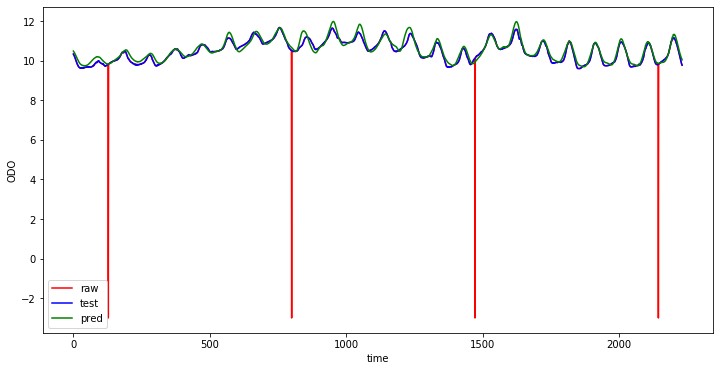

In [418]:
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(xx)), yrr,'r-',label="raw" )
# plt.plot(xx, ycc,'g-',label="corrected" )
plt.plot(np.arange(len(xx)), ytt,'b-',label="test" )
plt.plot(np.arange(len(xx)), ypp,'g-',label="pred" )
# plt.xticks()
plt.xlabel("time")
plt.ylabel(category)
plt.legend()
plt.show()

In [434]:
resid_corr = [ytt[i] - ypp[i] for i in range(len(ytt)) if ytt[i] > 0]
np.mean(np.square(np.array(resid_corr)))

0.027616409346547296

# anomaly classification

In [437]:
hs,ts, tp

(672, 96, 4)

In [444]:
# get mu and sig from train set
X_train, y_train = create_dataset(train_set, train_set[category], history_size=hs, target_size=ts, time_steps=tp)
y_esti = lstm_model.predict(X_train)

In [446]:
y_esti.shape

(3232, 96)

In [472]:
yt = []
start_index = hs
end_index = len(train_set) - ts
for i in range(start_index, end_index): # add target_size
    yt.append([train_set[category].iloc[i:i+1].index[0], i])
yt = pd.DataFrame(yt, columns=["LocalDateTime", "test_index"])
yt.shape

(3232, 2)

In [489]:
xx = []
yrr = []
ycc = []
ytt = []
ypp = []
yll = [] #labels

# corr_err = []
# pred_err = []
for k,v in yt.iterrows():
    xx.append(v["LocalDateTime"])
    yrr_val = s_raw[s_raw["LocalDateTime"] == v["LocalDateTime"]]["ODO"].values 
#     yrr_val = yrr_val[0] if yrr_val else -3
    yrr.append(yrr_val )
    
#     ycc.append( labels[labels["LocalDateTime"] == v["LocalDateTime"]]["ODO"].values[0] )
    yll.append( s_corr[s_corr["LocalDateTime"] == v["LocalDateTime"]]["QualifierCode"].values[0] )
    error_index = v["test_index"]
    ytt.append(( y_train[error_index-start_index][0] * train_std + train_mean).values[0] )
    ypp.append( (y_esti[error_index-start_index][0]* train_std + train_mean).values[0] )

KeyboardInterrupt: 

In [474]:
resids_train = np.array(ypp) - np.array(ytt)
yll_train = [ 0 if pd.isnull(y) else 1 for y in yll]

In [456]:
mu = resids_train.mean()
sig = resids_train.std()
mu, sig

(-0.014671139914986059, 0.16063968056481026)

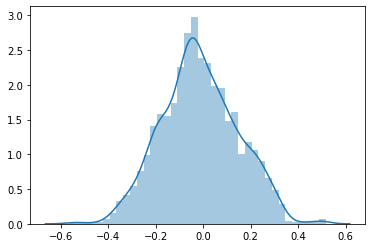

In [453]:
sns.distplot(resids_train)

In [480]:
from sklearn import metrics

In [481]:
resids = resids_train
labels_true = yll_train
pp = []
for rt in resids:
    p = gaussian(rt, mu,sig)
    pp.append(p)

Text(0, 0.5, 'f1-score')

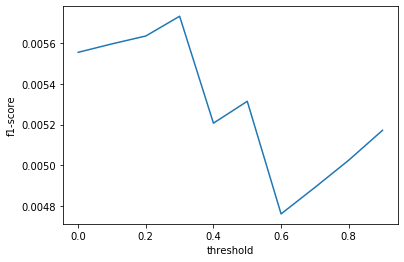

In [482]:
ths = np.arange(0,1,0.1)
fscores = []
for i in ths:
    threshold = i
    labels_pred = [1 if i >= threshold else 0 for i in pp]
    f1 = metrics.f1_score(labels_true, labels_pred)
    fscores.append(f1)

sns.lineplot(ths, fscores)
plt.xlabel("threshold")
plt.ylabel("f1-score")

In [484]:
threshold = ths[np.argmax(fscores)]
labels_pred = [1 if np.abs(i) >= threshold else 0 for i in resids]
f1 = metrics.f1_score(labels_true, labels_pred)
cm = metrics.confusion_matrix(labels_true, labels_pred , labels=[1,0])
print(f1)
print(cm)

0.010362694300518135
[[   1    8]
 [ 183 3040]]


In [492]:
yrr = [y if y>0 else -9999 for y in yrr]
resids_test = np.array(ypp) - np.array(ytt)
yll_test = [ 0 if pd.isnull(y) else 1 for y in yll]

In [493]:
resids = resids_test
labels_true = yll_test

pp = []
for rt in resids:
    p = gaussian(rt, mu,sig)
    pp.append(p)
    

labels_pred = [1 if np.abs(i) >= threshold else 0 for i in resids]
f1 = metrics.f1_score(labels_true, labels_pred)
cm = metrics.confusion_matrix(labels_true, labels_pred , labels=[1,0])
print(threshold)
print(f1)
print(cm)    

0.30000000000000004
0.0
[[   0    8]
 [ 137 2087]]


In [476]:
sum(yll_train)/len(yll_train)

0.0027846534653465345